# The Problem
I would like to use a recurrent neural network to predict Apple stock prices based on the open, high, low, and close values of Apple stock prices in the past. An RNN is appropriately suited to solve this problem because the data must be processed sequentially and its order taken into consideration when making a prediction of future stock prices.

# Task 1
### Exploratory Data Analysis

In [1]:
#import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import spacy

# data source: https://www.kaggle.com/datasets/rohiniselvaraj0107/stock-price-prediction-of-apple-inc
df = pd.read_csv('apple_share_price.csv', index_col='Date', parse_dates=['Date'])

2022-10-18 14:47:07.298887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 14:47:07.463680: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-18 14:47:07.463717: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-18 14:47:07.489253: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-18 14:47:11.852215: W tensorflow/stream_executor/platform/de

In [2]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-08-11,156.60,158.57,156.07,157.48,26257096
2017-08-10,159.90,160.00,154.63,155.32,40804273
2017-08-09,159.26,161.27,159.11,161.06,26131530
2017-08-08,158.60,161.83,158.27,160.08,36205896
2017-08-07,157.06,158.92,156.67,158.81,21870321


In [3]:
df.shape

(1664, 5)

In [4]:
df.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1664 entries, 2017-08-11 to 2011-01-03
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1664 non-null   float64
 1   High    1664 non-null   float64
 2   Low     1664 non-null   float64
 3   Close   1664 non-null   float64
 4   Volume  1664 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 78.0 KB


In [6]:
df.describe()

,Open,High,Low,Close,Volume
count,1664.000000,1664.00000,1664.000000,1664.000000,1.664000e+03
mean,91.604105,92.39149,90.760619,91.594525,7.958391e+07
std,28.258360,28.42185,28.094248,28.272351,5.446191e+07
min,45.240000,45.39000,44.360000,45.050000,1.147592e+07
25%,66.912500,67.59750,66.385000,66.835000,3.883495e+07
50%,92.150000,92.55500,90.950000,92.010000,6.576690e+07
75%,112.542500,113.75500,111.550000,112.650000,1.042734e+08
max,159.900000,161.83000,159.110000,161.060000,4.702467e+08


In [7]:
df['Close'].value_counts(normalize=True)

100.75    0.001803
77.78     0.001803
47.49     0.001803
83.65     0.001803
126.60    0.001803
            ...   
128.77    0.000601
130.19    0.000601
130.07    0.000601
130.06    0.000601
47.08     0.000601
Name: Close, Length: 1498, dtype: float64

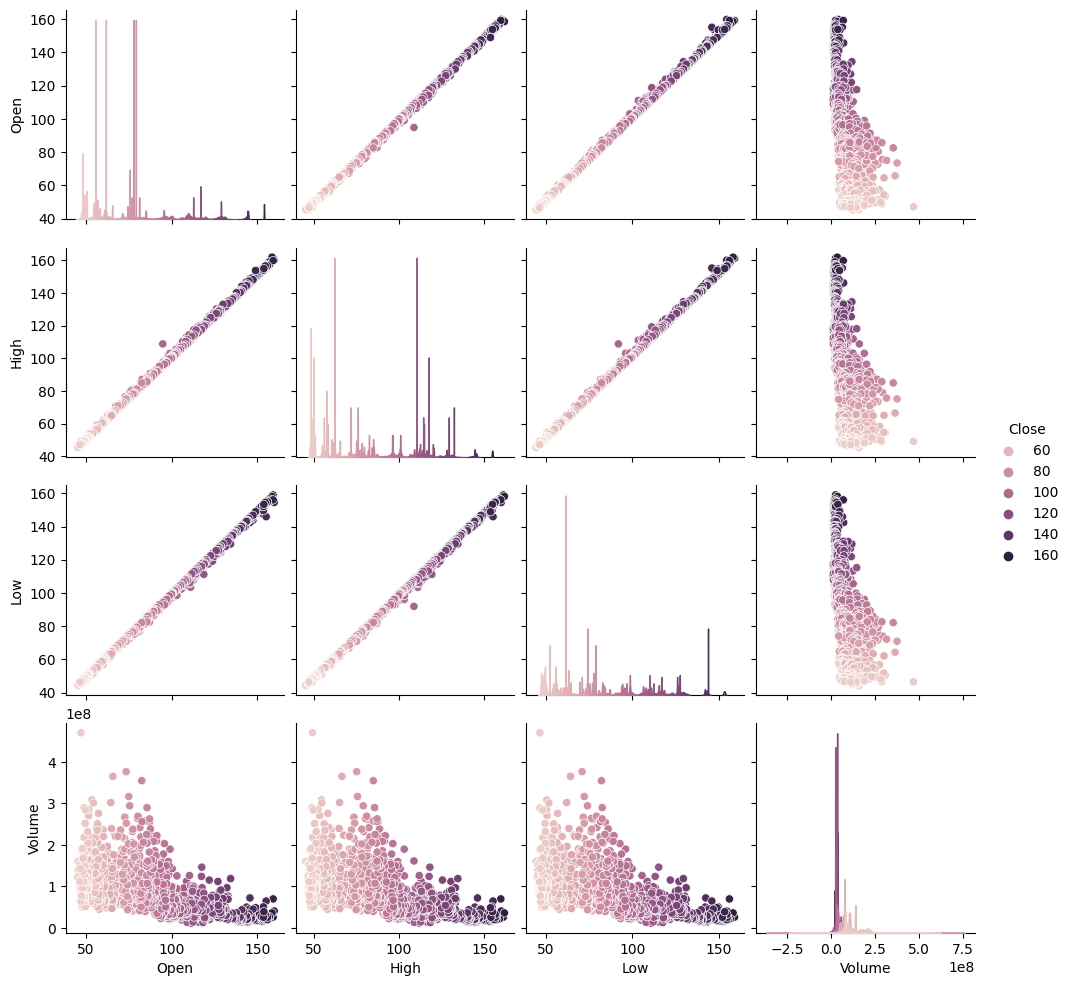

In [8]:
sns.pairplot(df,hue='Close')
plt.show()

### Implementing the RNN
I chose to add three types of layers to my RNN, two of which were simple RNN layers that both used the default hyberbolic tangent (tanh) activation function, and the third of which was a Dense layer using the linear activation function. To measure the performance of the model I used mean square error as my loss function. I experimented with adding dropout to my model, but found that it had little effect on accuracy but slowed convergence of the loss function, so I omitted it.

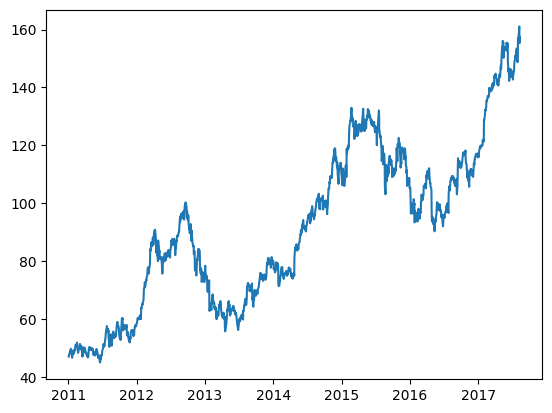

In [9]:
plt.plot(df['Close'])
plt.show()

In [10]:
data = df.loc[:,'Close']
sequence_length = 101
result = []

for i in range(len(data) - sequence_length):
    result.append(data[i: i + sequence_length])

normalized = []
for i in result:
    normalised_item = [((float(p) / float(i[0])) - 1) for p in i]
    normalized.append(normalised_item)
    
result = normalized

result = np.array(result)

row1 = round(0.8 * result.shape[0])
row2 = round(0.9 * result.shape[0])
train = result[:int(row1), :]
valid = result[int(row1):int(row2), :]
test = result[:-int(row2), :]
np.random.shuffle(train)
np.random.shuffle(valid)
np.random.shuffle(test)

x_train = train[:, :-1]
y_train = train[:, -1]
x_valid = valid[:, :-1]
y_valid = valid[:, -1]
x_test = test[:, :-1]
y_test = test[:, -1]

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

(1250, 100, 1)
(1250,)
(157, 100, 1)
(157,)
(156, 100, 1)
(156,)


In [11]:
model = Sequential()
model.add(layers.SimpleRNN(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(layers.SimpleRNN(100, return_sequences=False))
model.add(layers.Dense(1, activation = "linear"))

model.compile(loss='mse', optimizer='adam')
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100, 50)           2600      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               15100     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 17,801
Trainable params: 17,801
Non-trainable params: 0
_________________________________________________________________
None


2022-10-18 14:47:31.258510: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
hist = model.fit(x_train, y_train, batch_size=512, epochs=25, validation_data = (x_valid, y_valid))

Epoch 1/25
3/3 [==============================] - 2s 238ms/step - loss: 0.1189 - val_loss: 0.0352
Epoch 2/25
3/3 [==============================] - 0s 120ms/step - loss: 0.0252 - val_loss: 0.0061
Epoch 3/25
3/3 [==============================] - 0s 105ms/step - loss: 0.0091 - val_loss: 0.0042
Epoch 4/25
3/3 [==============================] - 0s 104ms/step - loss: 0.0067 - val_loss: 0.0045
Epoch 5/25
3/3 [==============================] - 0s 109ms/step - loss: 0.0045 - val_loss: 0.0038
Epoch 6/25
3/3 [==============================] - 0s 101ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 7/25
3/3 [==============================] - 0s 103ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 8/25
3/3 [==============================] - 0s 102ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 9/25
3/3 [==============================] - 0s 103ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 10/25
3/3 [==============================] - 0s 100ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 11/25
3/3 [==

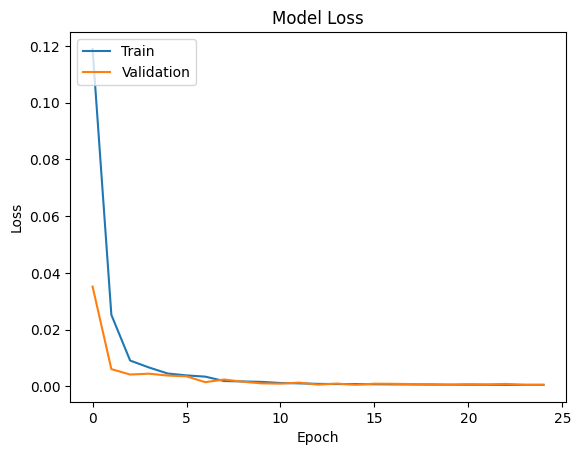

In [13]:
#show loss convergence
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
loss = model.evaluate(x_test, y_test, batch_size=512)
print("test loss:", loss)

1/1 [==============================] - 0s 35ms/step - loss: 4.9277e-04
test loss: 0.0004927710979245603


5/5 [==============================] - 0s 10ms/step


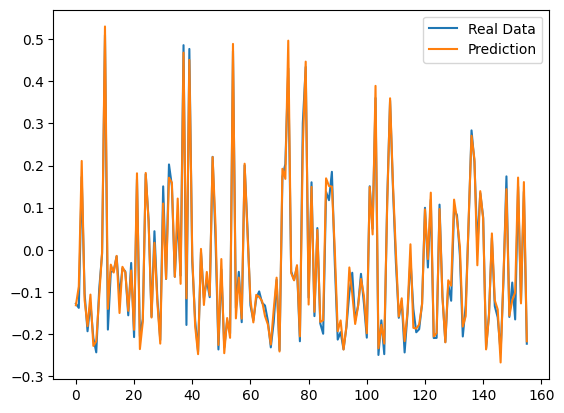

In [15]:
predicted = model.predict(x_test)
fig = plt.figure(facecolor='white') 
ax = fig.add_subplot(111) 
ax.plot(y_test, label='Real Data') 
plt.plot(predicted, label='Prediction') 
plt.legend() 
plt.show() 

### Part 2
##### LSTM

In [16]:
model_LSTM = Sequential()
model_LSTM.add(layers.LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model_LSTM.add(layers.LSTM(100, return_sequences=False))
model_LSTM.add(layers.Dense(1, activation = "linear"))

model_LSTM.compile(loss='mse', optimizer='adam')
print (model_LSTM.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
hist_LSTM = model_LSTM.fit(x_train, y_train, batch_size=512, epochs=25, validation_data = (x_valid, y_valid))

Epoch 1/25
3/3 [==============================] - 4s 625ms/step - loss: 0.0283 - val_loss: 0.0215
Epoch 2/25
3/3 [==============================] - 1s 345ms/step - loss: 0.0124 - val_loss: 0.0044
Epoch 3/25
3/3 [==============================] - 1s 337ms/step - loss: 0.0031 - val_loss: 0.0056
Epoch 4/25
3/3 [==============================] - 1s 355ms/step - loss: 0.0046 - val_loss: 0.0022
Epoch 5/25
3/3 [==============================] - 1s 344ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 6/25
3/3 [==============================] - 1s 325ms/step - loss: 0.0023 - val_loss: 0.0043
Epoch 7/25
3/3 [==============================] - 1s 321ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 8/25
3/3 [==============================] - 1s 330ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 9/25
3/3 [==============================] - 1s 322ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 10/25
3/3 [==============================] - 1s 311ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 11/25
3/3 [==

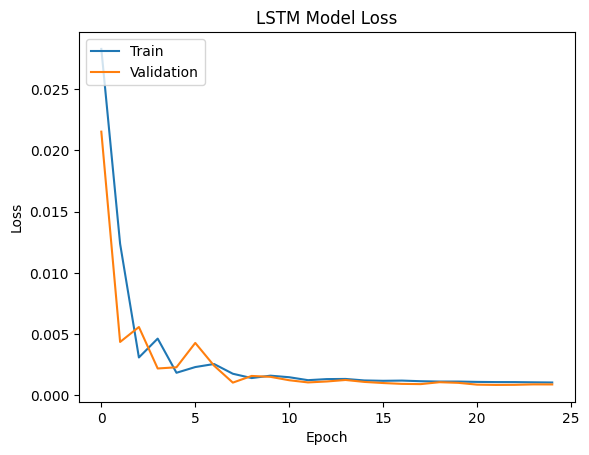

In [18]:
#show loss convergence
plt.plot(hist_LSTM.history['loss'])
plt.plot(hist_LSTM.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [19]:
loss_LSTM = model_LSTM.evaluate(x_test, y_test, batch_size=512)
print("test loss:", loss_LSTM)

1/1 [==============================] - 0s 68ms/step - loss: 0.0010
test loss: 0.0010211685439571738


5/5 [==============================] - 1s 21ms/step


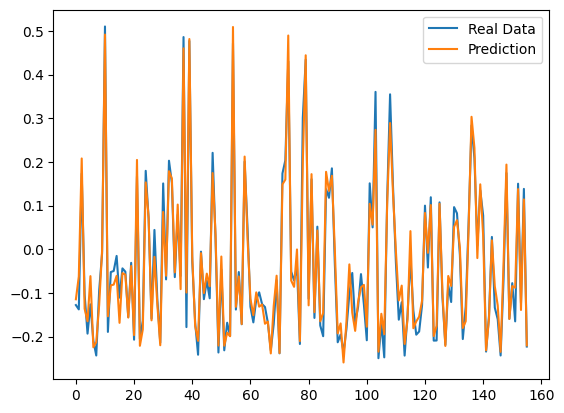

In [20]:
predicted_LSTM = model_LSTM.predict(x_test)
fig = plt.figure(facecolor='white') 
ax = fig.add_subplot(111) 
ax.plot(y_test, label='Real Data') 
plt.plot(predicted_LSTM, label='Prediction') 
plt.legend() 
plt.show() 

##### GRU

In [21]:
model_GRU = Sequential()
model_GRU.add(layers.GRU(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model_GRU.add(layers.GRU(100, return_sequences=False))
model_GRU.add(layers.Dense(1, activation = "linear"))

model_GRU.compile(loss='mse', optimizer='adam')
print (model_GRU.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100, 50)           7950      
                                                                 
 gru_1 (GRU)                 (None, 100)               45600     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 53,651
Trainable params: 53,651
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
hist_GRU = model_GRU.fit(x_train, y_train, batch_size=512, epochs=25, validation_data = (x_valid, y_valid))

Epoch 1/25
3/3 [==============================] - 3s 457ms/step - loss: 0.0301 - val_loss: 0.0203
Epoch 2/25
3/3 [==============================] - 1s 240ms/step - loss: 0.0138 - val_loss: 0.0077
Epoch 3/25
3/3 [==============================] - 1s 244ms/step - loss: 0.0032 - val_loss: 9.7788e-04
Epoch 4/25
3/3 [==============================] - 1s 229ms/step - loss: 0.0016 - val_loss: 0.0064
Epoch 5/25
3/3 [==============================] - 1s 256ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 6/25
3/3 [==============================] - 1s 244ms/step - loss: 0.0019 - val_loss: 7.3962e-04
Epoch 7/25
3/3 [==============================] - 1s 242ms/step - loss: 7.0596e-04 - val_loss: 5.8495e-04
Epoch 8/25
3/3 [==============================] - 1s 258ms/step - loss: 9.0038e-04 - val_loss: 0.0012
Epoch 9/25
3/3 [==============================] - 1s 244ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 10/25
3/3 [==============================] - 1s 240ms/step - loss: 0.0012 - val_loss: 0.0011

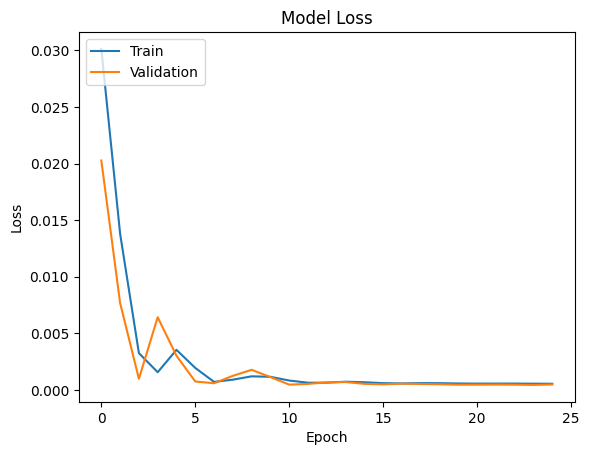

In [23]:
#show loss convergence
plt.plot(hist_GRU.history['loss'])
plt.plot(hist_GRU.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [24]:
loss_GRU = model_GRU.evaluate(x_test, y_test, batch_size=512)
print("test loss:", loss_GRU)

1/1 [==============================] - 0s 56ms/step - loss: 5.6540e-04
test loss: 0.000565397902391851


5/5 [==============================] - 0s 16ms/step


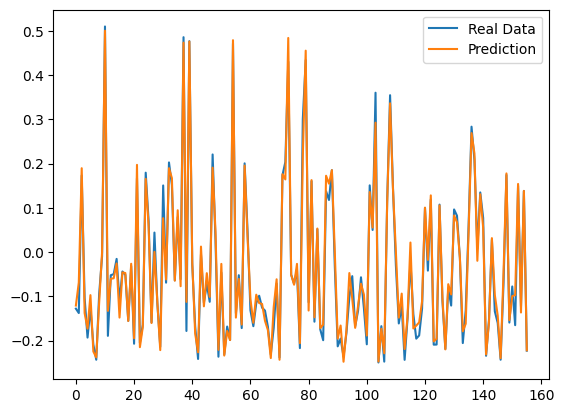

In [25]:
predicted_GRU = model_GRU.predict(x_test)
fig = plt.figure(facecolor='white') 
ax = fig.add_subplot(111) 
ax.plot(y_test, label='Real Data') 
plt.plot(predicted_GRU, label='Prediction') 
plt.legend() 
plt.show() 

##### Evaluation
Surprisingly, the simple RNN performed better than both LSTM and GRU. It had the lowest loss on the test set and the validation set. GRU had the second lowest losses and LSTM had the greatest. This could be because remembering longer sequences of data negatively impacts the accuracy of the model, for this particular data set. So, because the simple RNN has the shortest "memory", it produces a more accurate model. Furthermore, the simple RNN took less time to converge compared to LSTM and GRU. This occurance may also be due to this set of data working best with models with shorter sequences of "memory" or because LSTM and GRU are more complex than simple RNN and have more data to consider, so it may take longer to train them and have their loss functions converge.

### Part 3
A feed-forward network could be used to solve this problem but it would need to be adapted. In feed-forward neural networks data only flows in the forward direction, so to adapt this to time series data a "look back" range would need to be chosen as well as a prediction range, or how far ahead the model will need to predict. Then, the data would have to be broken up into units of the same length as the look back range for each data entry. These units can then be used to predict values that are in the prediction range for that data entry. For example, if the "look back" range was 4 and the prediction range was for the next 3 data entries, for data entry 5 the input may look like [Data5, Data6, Data7, Data8] and would predict [Data9, Data10, Data11].

# Task 2
To measure dissimilarity I chose to use Wasserstein distance because it is often used to measure the dissimilarity between two images or probability distributions and, like cosine similarity, is a distance function. Wasserstein distance is essentially the minimum "cost" of turning one vector into another, so intuitively it can be used to measure dissimilarity. More similar vectors will require fewer "moves" to turn into each other, and thus will incur less cost and have a lower Wasserstein distance. So, the more dissimilar two vectors are, the higher their Wasserstein distance.

In [26]:
def cosine_similarity(a, b):
    return a.dot(b)/np.sqrt(a.dot(a) * b.dot(b))

In [27]:
#Using Wasserstein distance to compute dissimilarity
#Sources: https://en.wikipedia.org/wiki/Wasserstein_metric

def first_nonzero(ar):
    dim = len(ar)
    for i in range(dim):
        if ar[i] > 0.0:
            return i
    return -1  # no cells found

def move(old, from_i, new, to_i):
    if old[from_i] <= new[to_i]:
        flow = old[from_i]
        old[from_i] = 0.0
        new[to_i] -= flow
    elif old[from_i] > new[to_i]:
        flow = new[to_i]
        old[from_i] -= flow
        new[to_i] = 0.0
    dist = np.abs(from_i - to_i)
    return flow, dist, a, b


def dissimilarity(a,b):
    newa = np.copy(a) 
    newb = np.copy(b)
    tot_work = 0.0
    
    while True:
        from_i = first_nonzero(newa)
        to_i = first_nonzero(newb)
        if from_i == -1 or to_i == -1:
            break
        (flow, dist, newa, newb) = move(newa, from_i, newb, to_i)
        tot_work += flow * dist
    return tot_work   
    

In [33]:
inpt = input()

A simple sample input sentence.


In [34]:
nlp = spacy.load('en_core_web_sm')

In [35]:
tokens = list(inpt.lower().split())
print(len(tokens))

5


In [36]:
vocab, index = {}, 1  # start indexing from 1
for token in tokens:
  if token not in vocab:
    vocab[token] = index
    index += 1
vocab_size = len(vocab)
print(vocab)

{'a': 1, 'simple': 2, 'sample': 3, 'input': 4, 'sentence.': 5}


In [37]:
for i in range(len(tokens)):
    j = i + 1
    while j < len(tokens):
        a = nlp(tokens[i]).vector
        b = nlp(tokens[j]).vector
        print("Cosine similarity between ", tokens[i], " and ", tokens[j], ": ", cosine_similarity(a,b))
        
        #normalize between 0 and 1 for dissimilarity
        a1 = (a - np.min(a)) / (np.max(a) - np.min(a))
        b1 = (b - np.min(b)) / (np.max(b) - np.min(b))
        print("Dissimilarity (Wasserstein distance) between ", tokens[i], " and ", tokens[j], ": ", dissimilarity(a1,b1))
        j = j+1

Cosine similarity between  a  and  simple :  0.33422694
Dissimilarity (Wasserstein distance) between  a  and  simple :  116.99523298442364
Cosine similarity between  a  and  sample :  0.20016846
Dissimilarity (Wasserstein distance) between  a  and  sample :  200.01004426181316
Cosine similarity between  a  and  input :  0.23085758
Dissimilarity (Wasserstein distance) between  a  and  input :  254.21690107882023
Cosine similarity between  a  and  sentence. :  0.13390936
Dissimilarity (Wasserstein distance) between  a  and  sentence. :  219.54435784369707
Cosine similarity between  simple  and  sample :  0.4459209
Dissimilarity (Wasserstein distance) between  simple  and  sample :  221.96166234463453
Cosine similarity between  simple  and  input :  0.38928366
Dissimilarity (Wasserstein distance) between  simple  and  input :  293.9781664311886
Cosine similarity between  simple  and  sentence. :  0.24678603
Dissimilarity (Wasserstein distance) between  simple  and  sentence. :  287.938718